In [1]:
import pandas as pd

In [5]:
ranking = '../evaluation/resources/2020/jsonruns/p_controller_default_nle_meta_9_1_theta=0.9.json'
eval_result = '../evaluation/resources/2020/eval_results/p_controller_default_nle_meta_9_1_theta=0.9.tsv'

In [32]:
gt = '../pre_processing/resources/evaluation/2020/TREC-Fair-Ranking-eval-sample.json'

In [6]:
rdf= pd.read_json(ranking,lines=True)

In [38]:
gtdf = pd.read_json(gt, lines=True).explode('documents')
gtdf['doc_id'] = gtdf.documents.apply(lambda row: row.get('doc_id'))
gtdf['doc_rel'] = gtdf.documents.apply(lambda row: row.get('relevance'))
reldf = gtdf[['qid','query','doc_id','doc_rel']]
reldf

,qid,query,doc_id,doc_rel
0,9087,lepidium sativum,40d8bea494d4ff4c46f7ad5cb2dcdaa6f96ed5a4,1
0,9087,lepidium sativum,008a2a2c765485af2e035a2572ba9fc1102eabff,1
0,9087,lepidium sativum,4a1472c575488ed9acee6c5481f68b95a0c34092,0
0,9087,lepidium sativum,ff8df0745136fb183ea72b783ff38f8a7ad5ceec,0
0,9087,lepidium sativum,90605deb1da5e3d5548da12dc130fc0341a6a255,0
0,9087,lepidium sativum,cbc33164f9db97698901f130f399f2898d856267,0
0,9087,lepidium sativum,6b70f398278146116baa4865582c36f5550f953a,0
0,9087,lepidium sativum,c68374b97eb2c214afd3c282175f664fc37c5682,0
0,9087,lepidium sativum,34ba4f3d2a38b88153308f2a7f12651b440f5812,0
0,9087,lepidium sativum,efe0b6115d460fcd2173fc04d113694f1ded8692,0


In [11]:
edf = pd.read_csv(eval_result, sep='\t', names=['key', 'qid', 'value'])
edf = edf.pivot(index='qid', columns='key', values='value')

In [15]:
edf.sort_values(by='difference')

key,difference,disparity,relevance
qid,,,
91643,0.019822,1.006921,0.868206
5191,0.044683,1.448939,1.344147
81479,0.046552,2.044160,1.889465
21237,0.053041,1.358547,1.149610
7363,0.053171,1.313280,1.085770
18112,0.057675,1.327767,1.079491
61688,0.061505,1.061153,0.834400
4319,0.063171,1.892463,1.585866
43723,0.065366,1.839158,1.496630


In [19]:
edf[edf.difference > edf.difference.mean()].sort_values(by='difference',ascending=False).head(10)

key,difference,disparity,relevance
qid,,,
657,3.700546,2.631709,0.255715
100510,3.252370,2.703133,0.514383
16607,3.034450,2.557715,0.550634
89881,1.987253,1.570899,0.577918
12885,1.941179,1.874742,0.848831
18060,1.725684,1.519402,0.684165
59483,1.619563,1.586472,0.469430
52501,1.429890,1.625181,0.943276
89569,1.210698,1.378091,0.572047


In [24]:
query_results = rdf[rdf.qid == 657]
query_results

,q_num,qid,ranking
24150,161.000,657,"[1436449e0234166b13135df45be1f072df059007, 863..."
24151,161.100,657,"[18f883bd5b9ab9771e561a0214af6bd5ddda0d61, 863..."
24152,161.200,657,"[e9cfbf58d87e9f5afae813e8b8294b7719c176da, b79..."
24153,161.300,657,"[128611b63b268a1bffb69d3276a11ae7f6b068d7, 3c9..."
24154,161.400,657,"[e686c4e74d9085c78813355d582102d973b157cf, b79..."
24155,161.500,657,"[a8b58f310e13c171ce7b7890d23860836cbc4534, 143..."
24156,161.600,657,"[863a0360e4345b2e106e4f44cd95821f68b28036, 3c9..."
24157,161.700,657,"[87596955211a23714a6c2fc2af2d00464d15f9b3, 480..."
24158,161.800,657,"[3589a8b05684193dfc55610c9a9fbcf6db490130, 147..."
24159,161.900,657,"[6b7ca72ca79251cded87c47608e5cc93e37b09f2, b79..."


# optie 4

How often is a rel file in a position versus a nonrel file?

In [107]:
# aggregate the position rel/nonrel counts
df = pd.DataFrame({'rank':list(range(1,len(query_results['ranking'].iloc[0])+1))})

In [109]:
df.head()

,rank
0,1
1,2
2,3
3,4
4,5


In [47]:
reldf[(reldf.qid == 657) & (reldf.doc_id == '1436449e0234166b13135df45be1f072df059007')].doc_rel.iloc[0]

0

In [52]:
countdict = {}

for idx, row in query_results.iterrows():
    for i,doc in enumerate(row['ranking']):
        if not i + 1 in countdict:
            countdict[i+1] = {'r':0,'nr':0}
        rel = reldf[(reldf.qid == 657) & (reldf.doc_id == doc)].doc_rel.iloc[0]
        if rel == 0:
            countdict[i+1]['nr'] = countdict[i+1]['nr'] + 1
        elif rel == 1:
            countdict[i+1]['r'] = countdict[i+1]['r'] + 1
        else:
            raise ValueError
        
        
        
        

In [53]:
countdict

{1: {'r': 1, 'nr': 149},
 2: {'r': 7, 'nr': 143},
 3: {'r': 4, 'nr': 146},
 4: {'r': 3, 'nr': 147},
 5: {'r': 4, 'nr': 146},
 6: {'r': 3, 'nr': 147},
 7: {'r': 5, 'nr': 145},
 8: {'r': 4, 'nr': 146},
 9: {'r': 7, 'nr': 143},
 10: {'r': 3, 'nr': 147},
 11: {'r': 7, 'nr': 143},
 12: {'r': 3, 'nr': 147},
 13: {'r': 6, 'nr': 144},
 14: {'r': 6, 'nr': 144},
 15: {'r': 4, 'nr': 146},
 16: {'r': 4, 'nr': 146},
 17: {'r': 6, 'nr': 144},
 18: {'r': 6, 'nr': 144},
 19: {'r': 11, 'nr': 139},
 20: {'r': 11, 'nr': 139},
 21: {'r': 4, 'nr': 146},
 22: {'r': 7, 'nr': 143},
 23: {'r': 8, 'nr': 142},
 24: {'r': 8, 'nr': 142},
 25: {'r': 7, 'nr': 143},
 26: {'r': 11, 'nr': 139},
 27: {'r': 9, 'nr': 141},
 28: {'r': 10, 'nr': 140},
 29: {'r': 6, 'nr': 144},
 30: {'r': 10, 'nr': 140},
 31: {'r': 5, 'nr': 145},
 32: {'r': 8, 'nr': 142},
 33: {'r': 9, 'nr': 141},
 34: {'r': 10, 'nr': 140},
 35: {'r': 9, 'nr': 141},
 36: {'r': 15, 'nr': 135},
 37: {'r': 19, 'nr': 131},
 38: {'r': 14, 'nr': 136},
 39: {'r': 1

In [69]:
complicatdo = [record for reclist in [[{**{'rank':k},**{'relkind':k2,'count':v2}} for k2,v2 in v.items()]  for k,v in countdict.items()] for record in reclist]
complicatdo[:10]

[{'rank': 1, 'relkind': 'r', 'count': 1},
 {'rank': 1, 'relkind': 'nr', 'count': 149},
 {'rank': 2, 'relkind': 'r', 'count': 7},
 {'rank': 2, 'relkind': 'nr', 'count': 143},
 {'rank': 3, 'relkind': 'r', 'count': 4},
 {'rank': 3, 'relkind': 'nr', 'count': 146},
 {'rank': 4, 'relkind': 'r', 'count': 3},
 {'rank': 4, 'relkind': 'nr', 'count': 147},
 {'rank': 5, 'relkind': 'r', 'count': 4},
 {'rank': 5, 'relkind': 'nr', 'count': 146}]

In [72]:
forsns = pd.DataFrame(complicatdo)
forsns.head(10)

,rank,relkind,count
0,1,r,1
1,1,nr,149
2,2,r,7
3,2,nr,143
4,3,r,4
5,3,nr,146
6,4,r,3
7,4,nr,147
8,5,r,4
9,5,nr,146


<AxesSubplot:xlabel='rank', ylabel='count'>

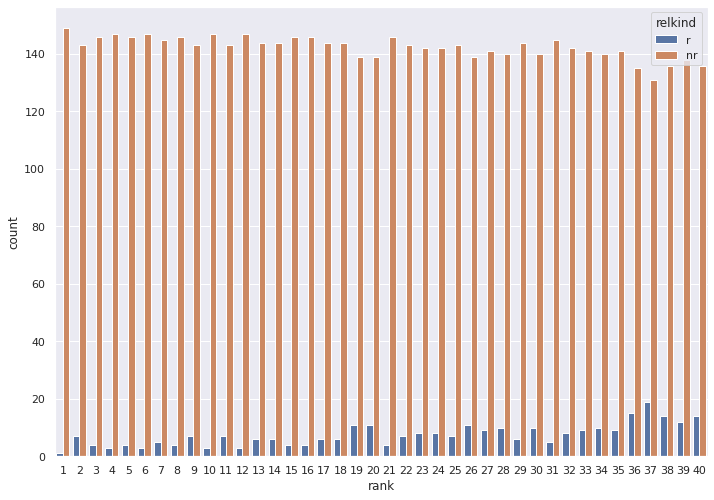

In [74]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x="rank", y="count", hue="relkind", data=forsns)

In [65]:
[{**{'rank':k},**v}  for k,v in countdict.items()]

[{'rank': 1, 'r': 1, 'nr': 149},
 {'rank': 2, 'r': 7, 'nr': 143},
 {'rank': 3, 'r': 4, 'nr': 146},
 {'rank': 4, 'r': 3, 'nr': 147},
 {'rank': 5, 'r': 4, 'nr': 146},
 {'rank': 6, 'r': 3, 'nr': 147},
 {'rank': 7, 'r': 5, 'nr': 145},
 {'rank': 8, 'r': 4, 'nr': 146},
 {'rank': 9, 'r': 7, 'nr': 143},
 {'rank': 10, 'r': 3, 'nr': 147},
 {'rank': 11, 'r': 7, 'nr': 143},
 {'rank': 12, 'r': 3, 'nr': 147},
 {'rank': 13, 'r': 6, 'nr': 144},
 {'rank': 14, 'r': 6, 'nr': 144},
 {'rank': 15, 'r': 4, 'nr': 146},
 {'rank': 16, 'r': 4, 'nr': 146},
 {'rank': 17, 'r': 6, 'nr': 144},
 {'rank': 18, 'r': 6, 'nr': 144},
 {'rank': 19, 'r': 11, 'nr': 139},
 {'rank': 20, 'r': 11, 'nr': 139},
 {'rank': 21, 'r': 4, 'nr': 146},
 {'rank': 22, 'r': 7, 'nr': 143},
 {'rank': 23, 'r': 8, 'nr': 142},
 {'rank': 24, 'r': 8, 'nr': 142},
 {'rank': 25, 'r': 7, 'nr': 143},
 {'rank': 26, 'r': 11, 'nr': 139},
 {'rank': 27, 'r': 9, 'nr': 141},
 {'rank': 28, 'r': 10, 'nr': 140},
 {'rank': 29, 'r': 6, 'nr': 144},
 {'rank': 30, 'r': 

In [62]:
rankdf = pd.DataFrame([{**{'rank':k},**v}  for k,v in countdict.items()])
rankdf.head()

,rank,r,nr
0,1,1,149
1,2,7,143
2,3,4,146
3,4,3,147
4,5,4,146


### optie 4.b
There are far more irrelevant items for especially a longer ranking, so it's better to place rel/nonrel on a separate barplot each.

In [76]:
forsns[forsns.relkind=='r']

,rank,relkind,count
0,1,r,1
2,2,r,7
4,3,r,4
6,4,r,3
8,5,r,4
10,6,r,3
12,7,r,5
14,8,r,4
16,9,r,7
18,10,r,3


<AxesSubplot:xlabel='rank', ylabel='count'>

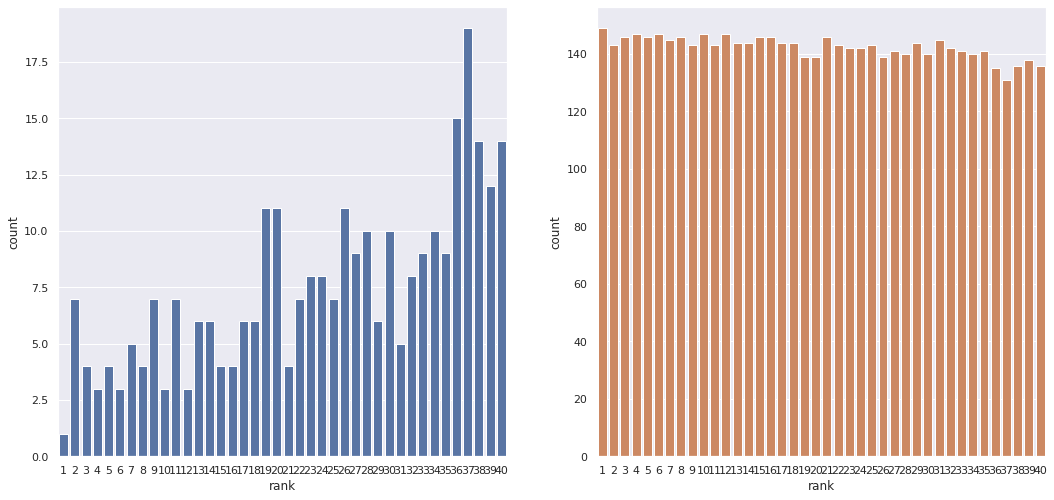

In [86]:

sns.set(rc={'figure.figsize':(17.7,8.27)})
pi = iter(sns.color_palette())
fig, ax =plt.subplots(1,2)
sns.barplot(x="rank", y="count", data=forsns[forsns.relkind=='r'],ax=ax[0],color=next(pi))
sns.barplot(x="rank", y="count", data=forsns[forsns.relkind=='nr'],ax=ax[1],color=next(pi))
# sns.countplot(forsns[forsns.relkind=='r'], ax=ax[0])
# sns.countplot(forsns[forsns.relkind=='nr'], ax=ax[1])


In [91]:
reldf[reldf.qid == 657].doc_rel.value_counts()

0    38
1     2
Name: doc_rel, dtype: int64

In [94]:
# 40P40 / (2!*38!)
from math import factorial as fact

fact(40)/(fact(2)*fact(38))

780.0

In [95]:
fact(2)

2

In [98]:
fact(38)

523022617466601111760007224100074291200000000

In [99]:
fact(2) * fact(38)

1046045234933202223520014448200148582400000000

In [97]:
fact(40)

815915283247897734345611269596115894272000000000

## foreach document, 
- compute how often it occurs in a "rel" position


## foreach position
that *should* be rel, compute which document(s) are there the most often

In [105]:
count_per_doc_per_rank = {i: {} for i in list(range(1,len(query_results['ranking'].iloc[0])+1))}

for idx, row in query_results.iterrows():
    for j, doc in enumerate(row['ranking']):
        i = j+1
        if not doc in count_per_doc_per_rank[i]:
            count_per_doc_per_rank[i][doc] = 0
        count_per_doc_per_rank[i][doc] = count_per_doc_per_rank[i][doc] + 1
count_per_doc_per_rank

{1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}, 15: {}, 16: {}, 17: {}, 18: {}, 19: {}, 20: {}, 21: {}, 22: {}, 23: {}, 24: {}, 25: {}, 26: {}, 27: {}, 28: {}, 29: {}, 30: {}, 31: {}, 32: {}, 33: {}, 34: {}, 35: {}, 36: {}, 37: {}, 38: {}, 39: {}, 40: {}}


{1: {'1436449e0234166b13135df45be1f072df059007': 7,
  '18f883bd5b9ab9771e561a0214af6bd5ddda0d61': 6,
  'e9cfbf58d87e9f5afae813e8b8294b7719c176da': 6,
  '128611b63b268a1bffb69d3276a11ae7f6b068d7': 5,
  'e686c4e74d9085c78813355d582102d973b157cf': 6,
  'a8b58f310e13c171ce7b7890d23860836cbc4534': 6,
  '863a0360e4345b2e106e4f44cd95821f68b28036': 5,
  '87596955211a23714a6c2fc2af2d00464d15f9b3': 2,
  '3589a8b05684193dfc55610c9a9fbcf6db490130': 3,
  '6b7ca72ca79251cded87c47608e5cc93e37b09f2': 4,
  'b7459d3aae88ba7720a806967706b362ecc50666': 4,
  'b59004dc46558189fa4d846029ccb1ce3f079484': 5,
  '3c9ee8bdf45ad8d8dff26eab50c2fa13083c2cec': 3,
  'b799814761b0569a9210c8e1e3e76f39a79aef35': 9,
  '48086bd4f74a8d2aa8a51d1b1406fbd0cad67f25': 2,
  '17475d93c5d0b5b6396aa1d3a3928d6154b65695': 2,
  '691fa56372d1a49ce9b442f2b58772b428eac694': 2,
  'dae9d969228c106ff36ac5ab8b79e47aa25075d2': 1,
  'f5b08b55cd9bc8ed6da9f184bebce390cc343c2f': 1,
  '147ef5b31e8a4ac481f429ea7734cdeb001c2089': 3,
  '3cc123e47454c1

In [131]:
perrank = [d for dlist in [[{'rank':k, 'doc_id':k2, 'count':v2} for k2, v2 in v.items()] for k,v in count_per_doc_per_rank.items()] for d in dlist]
perrankdf = pd.DataFrame(perrank)
perrankdf.head(10)

,rank,doc_id,count
0,1,1436449e0234166b13135df45be1f072df059007,7
1,1,18f883bd5b9ab9771e561a0214af6bd5ddda0d61,6
2,1,e9cfbf58d87e9f5afae813e8b8294b7719c176da,6
3,1,128611b63b268a1bffb69d3276a11ae7f6b068d7,5
4,1,e686c4e74d9085c78813355d582102d973b157cf,6
5,1,a8b58f310e13c171ce7b7890d23860836cbc4534,6
6,1,863a0360e4345b2e106e4f44cd95821f68b28036,5
7,1,87596955211a23714a6c2fc2af2d00464d15f9b3,2
8,1,3589a8b05684193dfc55610c9a9fbcf6db490130,3
9,1,6b7ca72ca79251cded87c47608e5cc93e37b09f2,4


In [133]:
forsnsperrank = pd.merge(perrankdf,reldf[reldf.qid == 657][['doc_id','doc_rel']],on='doc_id',how='left')
forsnsperrank.head(10)

,rank,doc_id,count,doc_rel
0,1,1436449e0234166b13135df45be1f072df059007,7,0
1,1,18f883bd5b9ab9771e561a0214af6bd5ddda0d61,6,0
2,1,e9cfbf58d87e9f5afae813e8b8294b7719c176da,6,0
3,1,128611b63b268a1bffb69d3276a11ae7f6b068d7,5,0
4,1,e686c4e74d9085c78813355d582102d973b157cf,6,0
5,1,a8b58f310e13c171ce7b7890d23860836cbc4534,6,0
6,1,863a0360e4345b2e106e4f44cd95821f68b28036,5,0
7,1,87596955211a23714a6c2fc2af2d00464d15f9b3,2,0
8,1,3589a8b05684193dfc55610c9a9fbcf6db490130,3,0
9,1,6b7ca72ca79251cded87c47608e5cc93e37b09f2,4,0


In [139]:
forsnsperrank.rank == 1

False

In [147]:
sns.set_palette("tab10")
pi = iter(sns.color_palette())
first = next(pi)
second = next(pi)


In [169]:
forsnsperrank[forsnsperrank['rank']== 1].sort_values(by='count',ascending=False).head(5)

,rank,doc_id,count,doc_rel
31,1,2aa5e431cd45476cc0432722dfa003a641790830,49,0
13,1,b799814761b0569a9210c8e1e3e76f39a79aef35,9,0
0,1,1436449e0234166b13135df45be1f072df059007,7,0
5,1,a8b58f310e13c171ce7b7890d23860836cbc4534,6,0
2,1,e9cfbf58d87e9f5afae813e8b8294b7719c176da,6,0


In [173]:
forsnsperrank[forsnsperrank['rank']== 2].sort_values(by='count',ascending=False).head(5)

,rank,doc_id,count,doc_rel
38,2,48086bd4f74a8d2aa8a51d1b1406fbd0cad67f25,10,0
46,2,a1b0feb1f82716b0e343453ca214912cfd3ea0e5,9,0
36,2,3c9ee8bdf45ad8d8dff26eab50c2fa13083c2cec,8,0
35,2,b799814761b0569a9210c8e1e3e76f39a79aef35,8,0
63,2,2aa5e431cd45476cc0432722dfa003a641790830,8,0


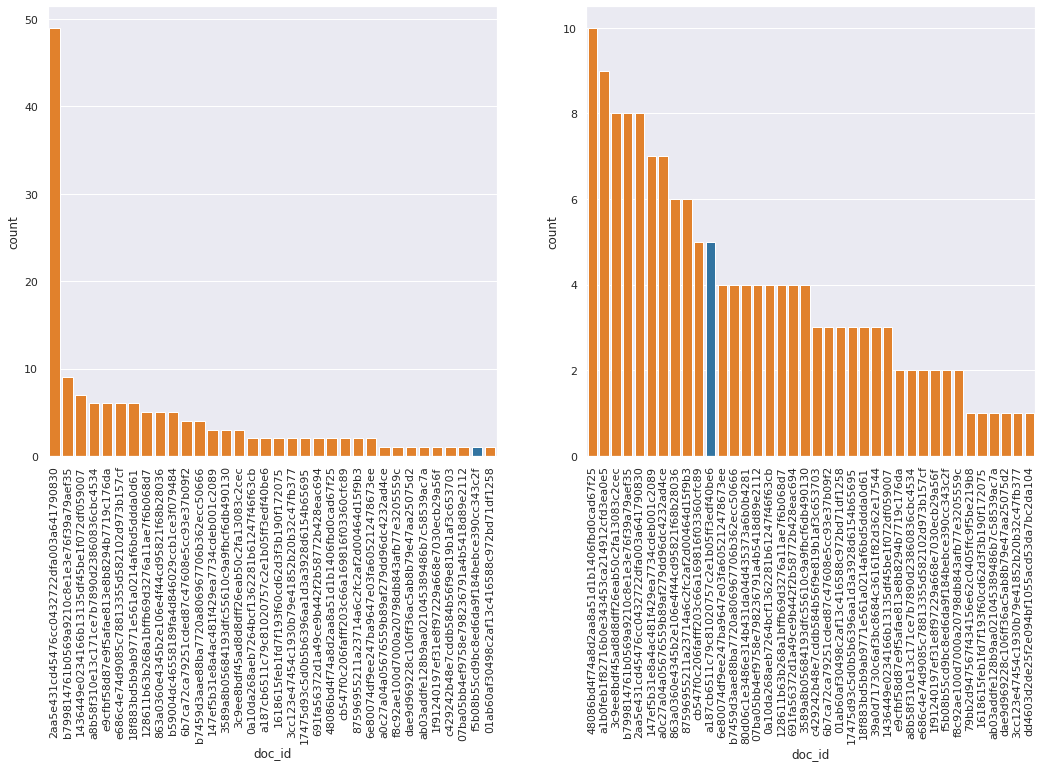

<Figure size 1080x576 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

In [163]:
fig, ax =plt.subplots(1,2)
for i in range(0,2):
    thisaxdata = forsnsperrank[forsnsperrank['rank']== i + 1]
    
    
    clrs = [first if rel == 1 else second for rel in thisaxdata.doc_rel.to_list() ]
    fig = plt.figure(figsize = (15,8))
    _ = sns.barplot(x="doc_id", y="count",palette=clrs, data=thisaxdata.sort_values(by='count',ascending=False),ax=ax[i])

    _ = ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation = 90)

_ = plt.show()

[Text(0, 0, '48086bd4f74a8d2aa8a51d1b1406fbd0cad67f25'),
 Text(1, 0, 'a1b0feb1f82716b0e343453ca214912cfd3ea0e5'),
 Text(2, 0, '3c9ee8bdf45ad8d8dff26eab50c2fa13083c2cec'),
 Text(3, 0, 'b799814761b0569a9210c8e1e3e76f39a79aef35'),
 Text(4, 0, '2aa5e431cd45476cc0432722dfa003a641790830'),
 Text(5, 0, '147ef5b31e8a4ac481f429ea7734cdeb001c2089'),
 Text(6, 0, 'a0c27a04a05676559b89af279dd96dc4232ad4ce'),
 Text(7, 0, '863a0360e4345b2e106e4f44cd95821f68b28036'),
 Text(8, 0, '87596955211a23714a6c2fc2af2d00464d15f9b3'),
 Text(9, 0, 'cb547f0c206fafff203c66a169816f03360cfc89'),
 Text(10, 0, 'a187cb6511c79c81020757c2e1b05ff3edf40be6'),
 Text(11, 0, '6e80074df9ee247ba9647e03fa605212478673ee'),
 Text(12, 0, 'b7459d3aae88ba7720a806967706b362ecc50666'),
 Text(13, 0, '80d06c1e3486e314b431da04d435373a6b0b4281'),
 Text(14, 0, '07ba05bb4ef9758e798236791a4b5418d89e2112'),
 Text(15, 0, '0a10da268aeb7264bcf1362281b61247f46f63cb'),
 Text(16, 0, '128611b63b268a1bffb69d3276a11ae7f6b068d7'),
 Text(17, 0, '691fa56372

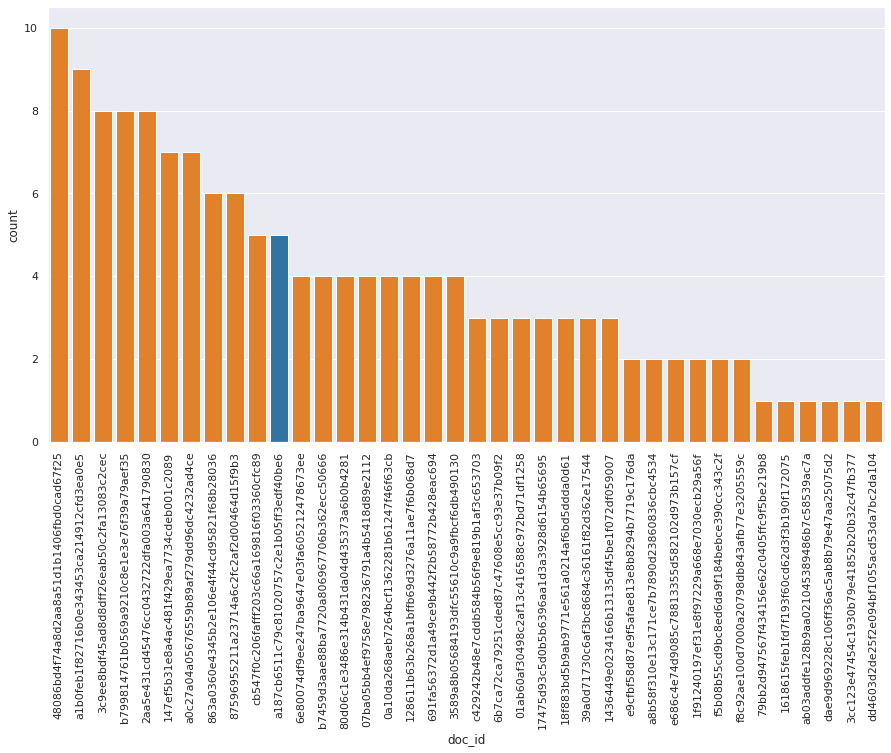

In [155]:
clrs = [first if rel == 1  else second for rel in forsnsperrank[forsnsperrank['rank']== 2].doc_rel.to_list() ]
fig = plt.figure(figsize = (15,8))
ax = sns.barplot(x="doc_id", y="count",palette=clrs, data=forsnsperrank[forsnsperrank['rank']== 2].sort_values(by='count',ascending=False),color=next(pi))

ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)


In [164]:
from elasticsearch import Elasticsearch
es = Elasticsearch()


In [172]:
es.search(index='semanticscholar2020og', body={'size':10,'query':{'ids':{'values':['2aa5e431cd45476cc0432722dfa003a641790830']}}})


{'took': 628,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 0, 'relation': 'eq'},
  'max_score': None,
  'hits': []}}

so, the top document for the worst query doesn't exist in the index. is this one of those documents that exist in the estimated rel files but not the index? --> yes
how are authorless docs treated in this case?
if there is no author, the advantage mean is set to 0. this means that the document is treated as never having an advantage so the hscore is always the same, namely hscore * rho(document)
the rho of 2aa5e431cd45476cc0432722dfa003a641790830 for nle meta is 0.0704727832842697

In [174]:
es.search(index='semanticscholar2020og', body={'size':10,'query':{'ids':{'values':['48086bd4f74a8d2aa8a51d1b1406fbd0cad67f25']}}})

{'took': 604,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 1, 'relation': 'eq'},
  'max_score': 1.0,
  'hits': [{'_index': 'semanticscholar2020og',
    '_type': 'document',
    '_id': '48086bd4f74a8d2aa8a51d1b1406fbd0cad67f25',
    '_score': 1.0,
    '_source': {'title': 'Historical Dictionary of Iran',
     'paperAbstract': "Part 1 List of Figures and Tables Part 2 Editor's Foreword Part 3 Preface Part 4 Acknowledgments Part 5 Reader's Notes Part 6 Acronyms and Abbreviations Part 7 Chronology Part 8 Introduction Part 9 Map Part 10 THE DICTIONARY Part 11 Appendix A: Basic Facts Part 12 Appendix B: Provinces: Area and Populations Part 13 Appendix C: Principal Towns and Populations Part 14 Appendix D: Text of UN Security Council Resolution 598 Part 15 Appendix E: Iranian Statesmen: 1787-2005 Part 16 Appendix F: Iranian Government Structure Part 17 Appendix G: Institutional Relationships of Government Part 18 Bibli